In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load the dataset
df = pd.read_csv('../../Data/pre_BTC-USD.csv')
data = df['Close'].values.reshape(-1, 1)

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [4]:
df= df.drop(columns=["Open", "High", "Low", "Adj Close","Volume"])
df = df.rename(columns={'Close': 'Price'})
df = pd.DataFrame(data=df)
df

,Date,Price
0,2018-03-01,10951.000000
1,2018-03-02,11086.400391
2,2018-03-03,11489.700195
3,2018-03-04,11512.599609
4,2018-03-05,11573.299805
...,...,...
2280,2024-05-28,68296.218750
2281,2024-05-29,67578.093750
2282,2024-05-30,68364.992188
2283,2024-05-31,67491.414063


In [5]:
# Chuyển đổi cột Date sang định dạng datetime64
df['Date'] = pd.to_datetime(df['Date'])

# Tạo cột Days_Since_Start và gán giá trị từ 1, 2, 3,...
df['Days_Since_Start'] = (df['Date'] - df['Date'].min()).dt.days + 1

# Kết quả
print(df)

           Date         Price  Days_Since_Start
0    2018-03-01  10951.000000                 1
1    2018-03-02  11086.400391                 2
2    2018-03-03  11489.700195                 3
3    2018-03-04  11512.599609                 4
4    2018-03-05  11573.299805                 5
...         ...           ...               ...
2280 2024-05-28  68296.218750              2281
2281 2024-05-29  67578.093750              2282
2282 2024-05-30  68364.992188              2283
2283 2024-05-31  67491.414063              2284
2284 2024-06-01  67706.937500              2285

[2285 rows x 3 columns]


In [6]:
y = df['Price'] 
X=df['Days_Since_Start'] 
X = pd.DataFrame(data=X)

y = pd.DataFrame(data=y)
# using the train test split function 9-1 
# X_train, X_test, y_train, y_test = train_test_split(X,y , random_state=104, test_size=0.3) 

split_index = int(len(X) * 0.9)

train_data=df[:split_index]
test_data=df[split_index:]
# Split the data by index
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [7]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p=1, start_q=1,
                   max_p=5, max_q=5, stationary=False,
                   start_P=0, seasonal=False,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit an ARIMA model to the training data using the best parameters found
model_fit = model.fit(y_train)

# Forecast the test_data
forecast = model_fit.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=34082.998, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34080.947, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34081.139, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34081.188, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34079.109, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.562 seconds


In [8]:
# Tính các chỉ số đánh giá
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
mape = np.mean(np.abs((y_test.values.flatten() - forecast) / y_test.values.flatten())) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')

MAE: 23196.43086452838
MSE: 710699778.9822241
MAPE: 41.021044534901435%


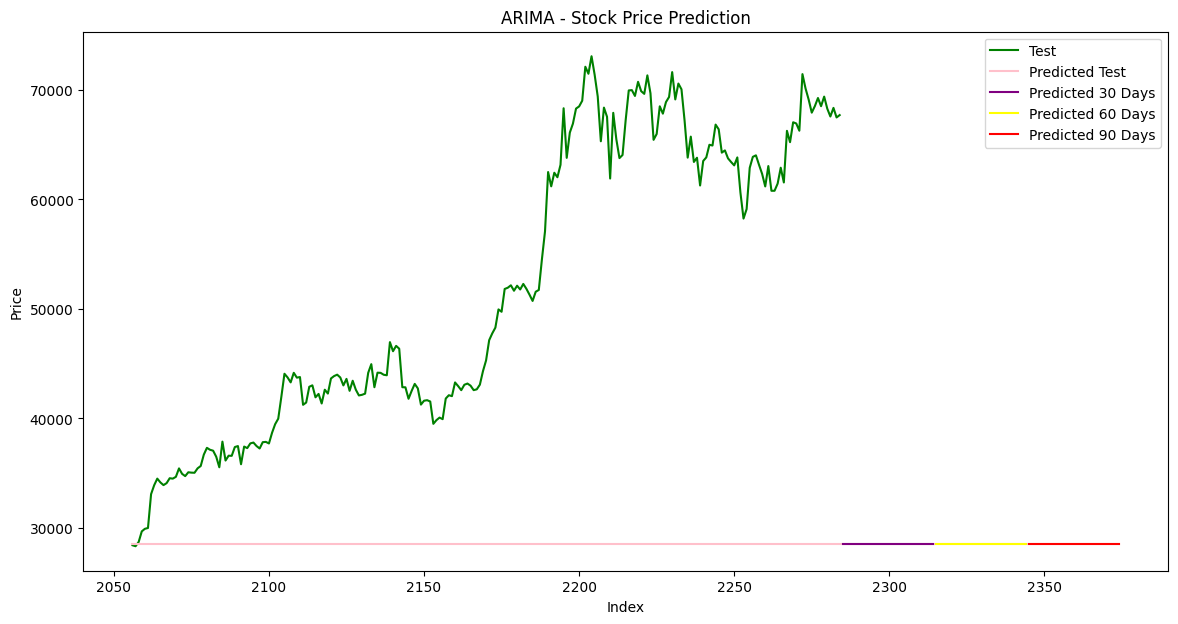

In [9]:
y_pred_future_30 = model_fit.predict(n_periods=30)
y_pred_future_60 = model_fit.predict(n_periods=30)
y_pred_future_90 = model_fit.predict(n_periods=30)

indices = np.arange(len(train_data) + len(test_data) + 90)

plt.figure(figsize=(14, 7))

# Plot the testing data
plt.plot(indices[len(train_data):len(train_data) + len(test_data)], test_data['Price'], label='Test', color='green')

#Plot predict line
y_pred = model_fit.predict(len(indices)-split_index)
plt.plot(indices[split_index:], y_pred, label='Predicted Test', color='pink')

# Plot the predicted future 'Price' values
plt.plot(indices[-90:-60], y_pred_future_30, label='Predicted 30 Days', color='purple')
plt.plot(indices[-60:-30], y_pred_future_60, label='Predicted 60 Days', color='yellow')
plt.plot(indices[-30:], y_pred_future_90, label='Predicted 90 Days', color='red')

# Set the title and labels
plt.title('ARIMA - Stock Price Prediction')
plt.xlabel('Index')
plt.ylabel('Price')

# Show legend
plt.legend()

# Display the plot
plt.show()

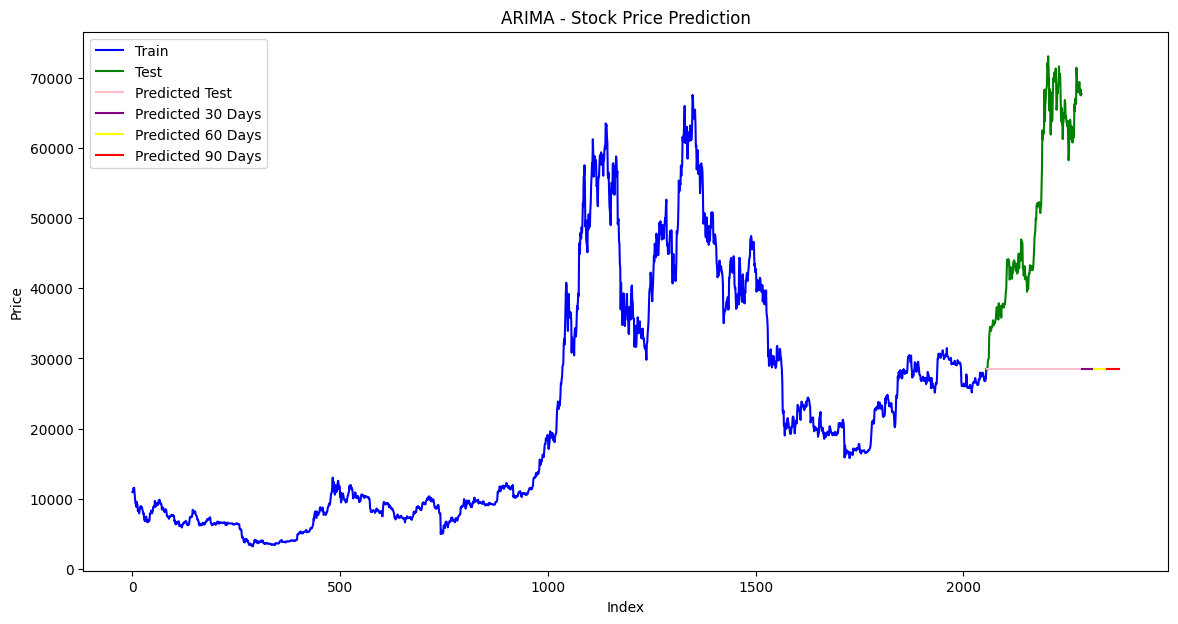

In [10]:
y_pred_future_30 = model_fit.predict(n_periods=30)
y_pred_future_60 = model_fit.predict(n_periods=30)
y_pred_future_90 = model_fit.predict(n_periods=30)

indices = np.arange(len(train_data) + len(test_data) + 90)

plt.figure(figsize=(14, 7))

# Plot the training data using the index range for the x-axis
plt.plot(indices[:len(train_data)], train_data['Price'], label='Train', color='blue')

# Plot the testing data
plt.plot(indices[len(train_data):len(train_data) + len(test_data)], test_data['Price'], label='Test', color='green')

#Plot predict line
y_pred = model_fit.predict(len(indices)-split_index)
plt.plot(indices[split_index:], y_pred, label='Predicted Test', color='pink')

# Plot the predicted future 'Price' values
plt.plot(indices[-90:-60], y_pred_future_30, label='Predicted 30 Days', color='purple')
plt.plot(indices[-60:-30], y_pred_future_60, label='Predicted 60 Days', color='yellow')
plt.plot(indices[-30:], y_pred_future_90, label='Predicted 90 Days', color='red')

# Set the title and labels
plt.title('ARIMA - Stock Price Prediction')
plt.xlabel('Index')
plt.ylabel('Price')

# Show legend
plt.legend()

# Display the plot
plt.show()

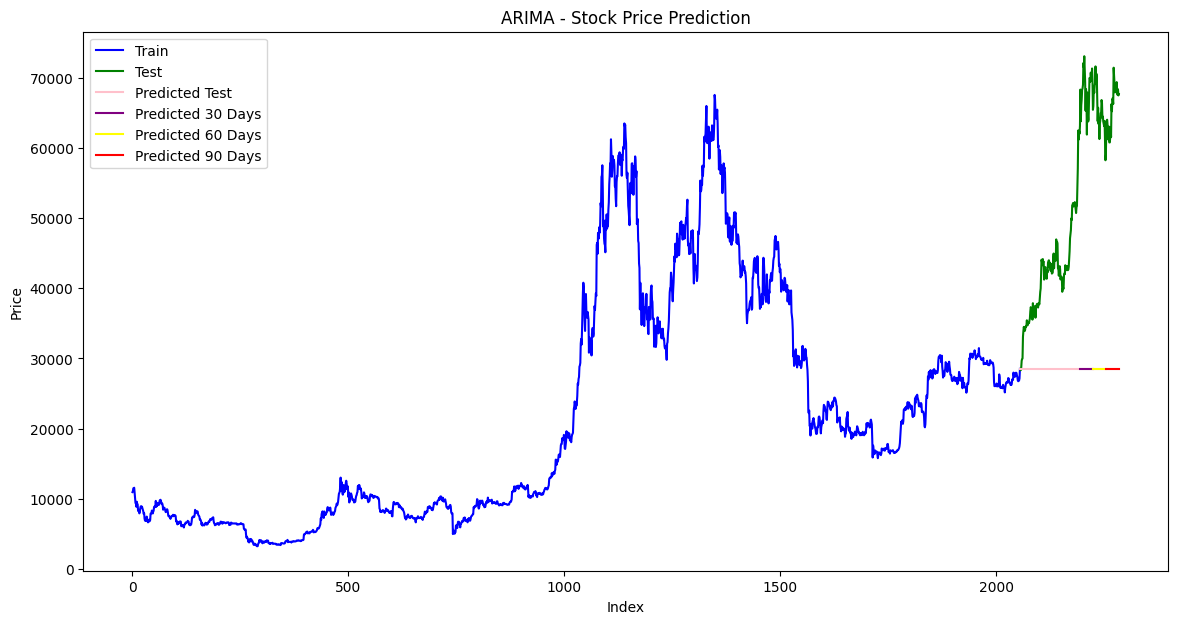

In [11]:
y_pred_future_30 = model_fit.predict(n_periods=30)
y_pred_future_60 = model_fit.predict(n_periods=30)
y_pred_future_90 = model_fit.predict(n_periods=30)

indices = np.arange(len(train_data) + len(test_data))

plt.figure(figsize=(14, 7))

# Plot the training data using the index range for the x-axis
plt.plot(indices[:len(train_data)], train_data['Price'], label='Train', color='blue')

# Plot the testing data
plt.plot(indices[len(train_data):len(train_data) + len(test_data)], test_data['Price'], label='Test', color='green')

#Plot predict line
y_pred = model_fit.predict(len(indices)-split_index)
plt.plot(indices[split_index:], y_pred, label='Predicted Test', color='pink')

# Plot the predicted future 'Price' values
plt.plot(indices[-90:-60], y_pred_future_30, label='Predicted 30 Days', color='purple')
plt.plot(indices[-60:-30], y_pred_future_60, label='Predicted 60 Days', color='yellow')
plt.plot(indices[-30:], y_pred_future_90, label='Predicted 90 Days', color='red')

# Set the title and labels
plt.title('ARIMA - Stock Price Prediction')
plt.xlabel('Index')
plt.ylabel('Price')

# Show legend
plt.legend()

# Display the plot
plt.show()